# **Y.Afisha: Optimización de  los gastos de marketing.**


* Registros del servidor con datos sobre las visitas a Y.Afisha desde enero de 2017 hasta diciembre de 2018: `visits_log`
* Archivo de volcado con todos los pedidos del período: `orders_log`
* Estadísticas de gastos de marketing: `costs_log`

Con la información de estos datasets vamos a investigar el comportamiento de los compradores en cuanto a cómo la gente usa el producto, cuándo empiezan a comprar, cuánto dinero trae cada cliente y cuándo pagan.

**Descripción de los datos:**
1. La tabla `visits_log` (registros del servidor con datos sobre las visitas al sitio web) contiene las siguientes columnas:
* Uid — identificador único del usuario
* Device — dispositivo del usuario
* Start Ts — fecha y hora de inicio de la sesión
* End Ts — fecha y hora de término de la sesión
* Source Id — identificador de la fuente de anuncios de la que proviene el usuario (todas las fechas de esta tabla están en formato AAAA-MM-DD).
2. La tabla `orders_log` (datos sobre pedidos):
* Uid — identificador único del usuario que realiza un pedido
* Buy Ts — fecha y hora del pedido
* Revenue — Ingresos de Y.Afisha de este pedido
3. La tabla `costs_log` (datos sobre gastos de marketing):
* source_id — identificador de la fuente de anuncios
* dt — fecha
* costs — gastos en esta fuente de anuncios en este día


## **Paso 1. Preprocesamiento de datos**

In [ ]:
import pandas   as pd
from scipy import stats as st
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
visits_log = pd.read_csv('https://code.s3.yandex.net/datasets/visits_log_us.csv')
orders_log = pd.read_csv('https://code.s3.yandex.net/datasets/orders_log_us.csv')
costs_log = pd.read_csv('https://code.s3.yandex.net/datasets/costs_us.csv')

### **Visitas al sitio web**

In [ ]:
visits_log.info() # Todas las columnas tienen la misma cantidad de filas, lo cual quiere decir que no hay filas vacías.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [ ]:
visits_log.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']
visits_log['end_ts'] = pd.to_datetime(visits_log['end_ts'], format='%Y.%m.%d %H:%M:%S')
visits_log['start_ts'] = pd.to_datetime(visits_log['start_ts'], format='%Y.%m.%d %H:%M:%S')
visits_log.head(10)

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063


En esta sección lo primero que hemos realizado es revisar el tipo de datos que hay en este dataframe y convertirlos a los datos más convenientes en los que los podemos tener para en análisis posterior, y también cambiamos el nombre de las columnas para que fuera más sencillo entenderlos conforme avanzamos con el proyecto. Todo se paso a minúsculas, se colocaron quines bajos y las columnas de fechas se convirtieron a tipo datetime.

### **Órdenes**

In [ ]:
orders_log.info() # No null values en este dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [ ]:
orders_log.columns = ['buy_ts', 'rev', 'uid'] # Convirtiendo los timestamps a datetime y corrigiendo nombres de columnas
orders_log['buy_ts'] = pd.to_datetime(orders_log['buy_ts'], format='%Y.%m.%d %H:%M:%S')
orders_log.head(10)

,buy_ts,rev,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
5,2017-06-01 08:43:00,0.18,10402394430196413321
6,2017-06-01 08:54:00,1.83,12464626743129688638
7,2017-06-01 09:22:00,1.22,3644482766749211722
8,2017-06-01 09:22:00,3.30,17542070709969841479
9,2017-06-01 09:23:00,0.37,1074355127080856382


In [ ]:
orders_log.duplicated('uid').sum() 

13892

Aquí lo que estamos encontrando con estos duplicados es que hay 13,892 usuarios repetidos, lo cual quiere decir que hay usuarios que han hecho compras más de una vez.

### **Costos**

In [ ]:
costs_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [ ]:
costs_log['dt'] = pd.to_datetime(costs_log['dt'], format='%Y.%m.%d %H:%M:%S')
costs_log.head(10) # Tipo de datos y no nulls

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
5,1,2017-06-06,40.39
6,1,2017-06-07,40.59
7,1,2017-06-08,56.63
8,1,2017-06-09,40.16
9,1,2017-06-10,43.24


## **Paso 2. Informes y métricas**

### Producto

* En esta sección vamos a analizar los datos de la tabla `visits_log`. Y de acuerdo con los registros de cada usuario al visitar la plataforma vamos a determinar:
1. El número de personas (usuarios) que nos visitan cada día, semana y mes.
2. El número de sesiones suceden en un día tomando en cuenta que un usuario puede tener más de una sesión.
3. La duración de cada sesión, en segundos
4. La frecuencia con que los usuarios regresan


In [ ]:
visits_log['month'] = pd.to_datetime(visits_log['start_ts']).dt.month
visits_log['week'] = pd.to_datetime(visits_log['start_ts']).dt.week
visits_log['day'] = pd.to_datetime(visits_log['start_ts']).dt.day
visits_log['year']   = pd.to_datetime(visits_log['start_ts']).dt.year
visits_log['duration'] = (visits_log['end_ts'] - visits_log['start_ts']).dt.seconds
visits_log.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


,device,end_ts,source_id,start_ts,uid,month,week,day,year,duration
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,12,51,20,2017,1080
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2,8,19,2018,1680
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,7,26,1,2017,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,5,20,20,2018,1440
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,12,52,27,2017,0
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,9,35,3,2017,60
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451,1,5,30,2018,3360
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312,11,44,5,2017,60
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644,7,29,19,2017,180
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063,11,45,8,2017,60


Primero lo que hemos hecho con el dataframe es extraer los meses, semanas, días, años y la duración de cada sesión, como nuevas columnas para el dataframe que nos van a ayudar a los análisis posteriores. Abajo tenemos la información de cada columna nueva.

In [ ]:
visits_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359400 non-null  object        
 1   end_ts     359400 non-null  datetime64[ns]
 2   source_id  359400 non-null  int64         
 3   start_ts   359400 non-null  datetime64[ns]
 4   uid        359400 non-null  uint64        
 5   month      359400 non-null  int64         
 6   week       359400 non-null  int64         
 7   day        359400 non-null  int64         
 8   year       359400 non-null  int64         
 9   duration   359400 non-null  int64         
dtypes: datetime64[ns](2), int64(6), object(1), uint64(1)
memory usage: 27.4+ MB


#### **1. El número de personas (usuarios) que nos visitan cada día, semana y mes.**

Ahora vamos a analizar la actividad de los usuarios por mes, semana y día. Vamos a calcular la cantidad de usuarios que se encuentran activos únicos para cada periodo de tiempo y calcularemos también la tasa de retención mensual y semanal (sticky factor).

In [ ]:
dau = visits_log.groupby(['day','month','year']).agg({'uid':'nunique'}).mean()
wau = visits_log.groupby(['week','year']).agg({'uid':'nunique'}).mean()
mau = visits_log.groupby(['month','year']).agg({'uid':'nunique'}).mean()

print('{:} usuarios únicos que utilizan la plataforma al día.'.format(int(dau)))
print('{:} usuarios únicos que utilizan la plataforma a la semana'.format(int(wau)))
print('{:} usuarios únicos que utilizan la plataforma al mes'.format(int(mau)))

907 usuarios únicos que utilizan la plataforma al día.
5716 usuarios únicos que utilizan la plataforma a la semana
23228 usuarios únicos que utilizan la plataforma al mes


In [ ]:
dau_graph = visits_log.groupby(['year','month','day']).agg({'uid':'nunique'})
dau_graph = dau_graph.reset_index()

dau_graph['day'] = dau_graph['day'].astype('string')
dau_graph['month'] = dau_graph['month'].astype('string')
dau_graph['year'] = dau_graph['year'].astype('string')

dau_graph['week_date'] = dau_graph['day'] + '.' + dau_graph['month']


In [ ]:
mau_graph = visits_log.groupby(['year','month']).agg({'uid':'nunique'})
mau_graph = mau_graph.reset_index()

mau_graph['month'] = mau_graph['month'].astype('string')
mau_graph['year'] = mau_graph['year'].astype('string')

mau_graph['mm_yyyy'] = mau_graph['month'] + '.' + mau_graph['year']
x_pos = np.arange(len(mau_graph['uid']))

Aquí creamos lo necesario para graficar el DAU y el MAU


Text(0, 0.5, 'Usuarios')

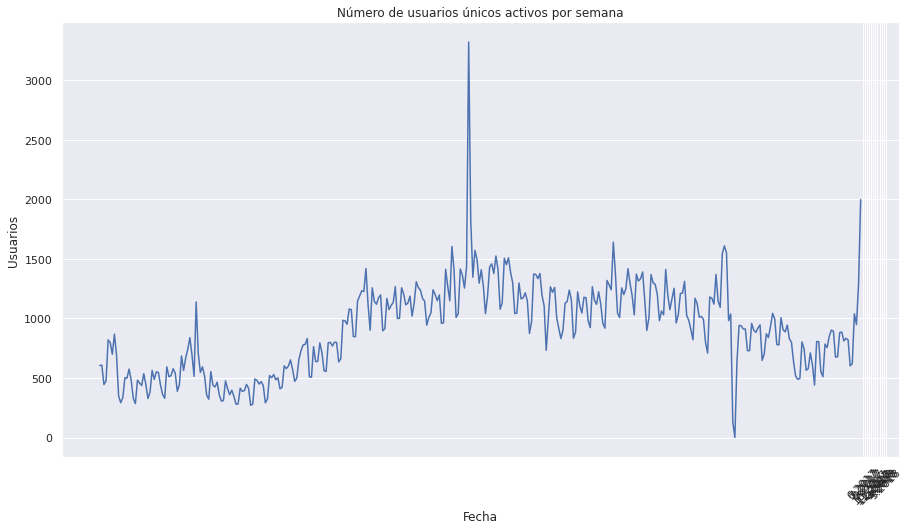

In [ ]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(data=dau_graph, x="week_date", y="uid").set(title="Número de usuarios únicos activos por semana")
plt.xticks(mau_graph['mm_yyyy'], rotation=45)
plt.xlabel("Fecha")
plt.ylabel("Usuarios")

Ene sta gráfica podemos observar que el DAU varía bastante conforme pasan los días, podemos ver que hay un incremento gradual en la primera mitad de la gráfica pero posteriormente disminuye la cantidad de usuarios únicos después del pico en Novimebre.

Text(0, 0.5, 'Usuarios')

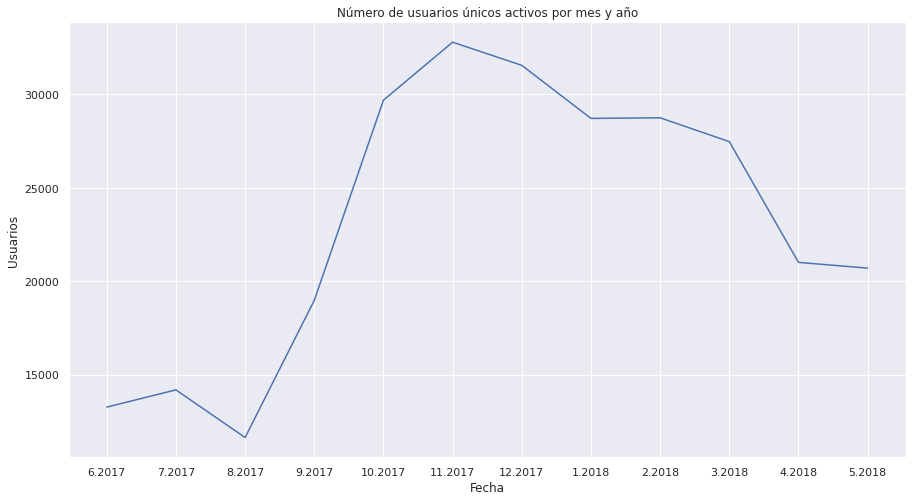

In [ ]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(data=mau_graph, x="mm_yyyy", y="uid").set(title="Número de usuarios únicos activos por mes y año")
plt.xlabel("Fecha")
plt.ylabel("Usuarios")

En esta gráfica sobre la tasa de retención, podemos observar que el numéro de usuarios se triplica si comparamos los meses de Agosto y Noviembre, de igual forma de prestando atención en la estación, el invierno tuvo mayor tasa de retención de usuarios que el verano. Ahora vamos a calcular las sesiones por usuario y el ASL (average session lenght). Vamos a utilizar la columna de la duración que habíamos agregado al principio de la sección para el ASL, y para la cantidad de sesiones de usuarios por año y mes vamos utilizar la proporción entre los usuarios y el número de sesiones.

#### **2. El número de sesiones suceden en un día tomando en cuenta que un usuario puede tener más de una sesión.**

In [ ]:
sessions_per_user = visits_log.groupby(['year', 'month', 'day']).agg({'uid': ['count','nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sess_per_user'] = (sessions_per_user['n_sessions'] /sessions_per_user['n_users'])
print(sessions_per_user) 

                n_sessions  n_users  sess_per_user
year month day                                    
2017 6     1           664      605       1.097521
           2           658      608       1.082237
           3           477      445       1.071910
           4           510      476       1.071429
           5           893      820       1.089024
...                    ...      ...            ...
2018 5     27          672      620       1.083871
           28         1156     1039       1.112608
           29         1035      948       1.091772
           30         1410     1289       1.093871
           31         2256     1997       1.129695

[364 rows x 3 columns]


Aquí hemos calculado la cantidad de sesiones que tiene cada usuario de acuerdo con el número de usuarios únicos y el número de sesiones que hay, agrupado por mes. Podemos ver que al mes, cada usuario único tiene al menos una sesión registrada, y con los números que vemos en la tabla podemos ver que el mes de Noviembre es el mes con más sesiones y con más usuarios activos. Contamos con 43969 sesiones y 32797 usuarios es más del doble de usuarios activos que con los que comenzamos en Julio del mismo año, 266% más.

#### **3. La duración de cada sesión, en segundos**

Text(0, 0.5, 'Usuarios')

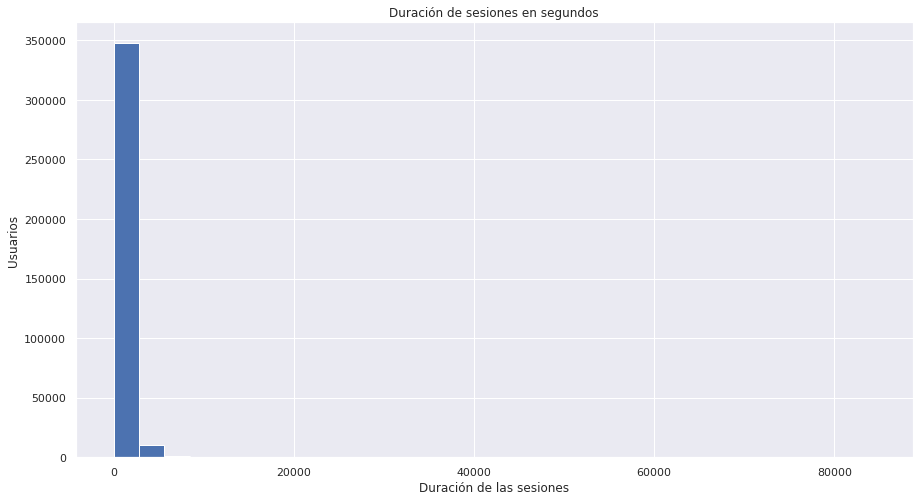

In [ ]:
visits_log['duration'].hist(figsize=(15, 8), bins=30)
plt.title('Duración de sesiones en segundos')
plt.xlabel("Duración de las sesiones")
plt.ylabel("Usuarios")

En esta gráfica podemos ver que las sesiones van de los 0 segundos hasta los 8000. Esto debe ser por diferentes razones, las sesiones extremadamente cortas pueden ser debido a errores de conexión, mientras que las sesiones extremadamente largas puede ser que el usuario dejó la aplicación running in the background o que haya olvidado cerrar su sesión. Vamos a encargarnos de eliminar los valores atípicos que puedan afectar el análisis de estos datos posteriormente.

<div class="alert alert-success">
<b>✔️ Comentario del revisor:</b> Buen trabajo!

In [ ]:
def outliers_lower_upper(name_df,column):
    q1 = name_df[column].quantile(0.25)
    q3 = name_df[column].quantile(0.75)
    iqr = q3 - q1
    if q1 - iqr*1.5 < 0:
        return (0, q3 + iqr*1.5)
    else:
        return (q1 - iqr*1.5, q3 + iqr*1.5)

outliers_duration_sessions = outliers_lower_upper(visits_log,'duration')

<div class="alert alert-success">
<b>✔️ Comentario del revisor:</b> Aqui puedes usar case

In [ ]:
no_outliers_visits = (visits_log[visits_log['duration'] < outliers_duration_sessions[1]])
print(len(no_outliers_visits.query('duration == 0')))

35794


Esta es la cantidad de sesiones que hay con duración de 0 segundos!

Text(0, 0.5, 'Usuarios')

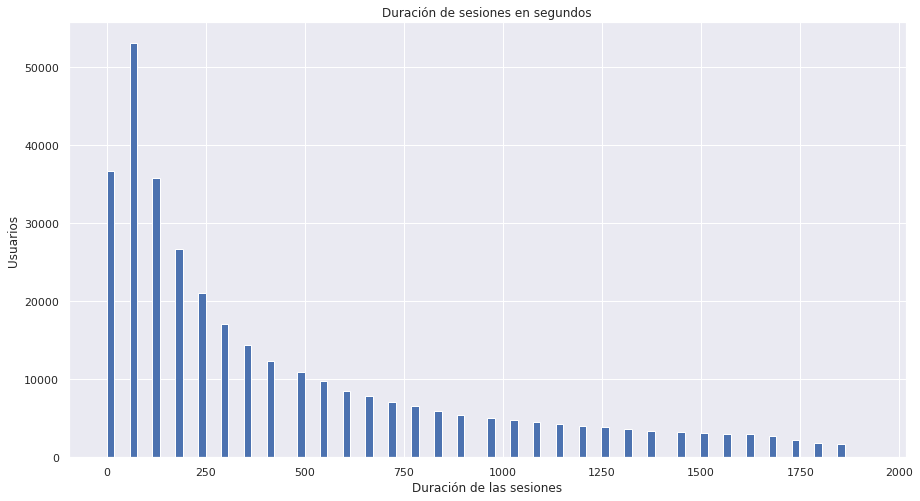

In [ ]:
plt.hist(no_outliers_visits['duration'], bins= 100, range=(0,1920))
plt.title('Duración de sesiones en segundos')
plt.xlabel("Duración de las sesiones")
plt.ylabel("Usuarios")

In [ ]:
asl_mean = no_outliers_visits['duration'].mean()
print('{:} segundos es el average session lenght para los usuarios de la aplicación, en promedio'.format(int(asl_mean)))

438 segundos es el average session lenght para los usuarios de la aplicación, en promedio


In [ ]:
asl_mode = no_outliers_visits['duration'].mode()
print('{:} segundos es la duración más frecuente para la session lenght entre los usuarios de la aplicación'.format(int(asl_mode)))

60 segundos es la duración más frecuente para la session lenght entre los usuarios de la aplicación


#### **4. La frecuencia con que los usuarios regresan**

In [ ]:
sticky_mau = dau/mau * 100
print('{:} es la tasa de retención de usuarios únicos al mes'.format(float(sticky_mau)))

3.908969652437603 es la tasa de retención de usuarios únicos al mes


In [ ]:
sticky_wau = dau/wau * 100
print('{:} es la tasa de retención de usuarios únicos a la semana'.format(float(sticky_wau)))

15.88440861589881 es la tasa de retención de usuarios únicos a la semana


Con los sticky factors calculados podemos concluir que al mes, los usuarios utilizan la app durante un 3.9% del tiempo lo cual se traduce en 1.17 días o 28 horas que los usuarios pasan en la app. Semanalmente, tenemos que los usuarios tienen un engagement del 15%, lo cual se puede traducir en 1.19 días o 28.5 horas que pasasn los usuarios en la app. 

### Ventas

En esta sección vamos a analizar las ventas:
1. Momento en que la gente empieza a comprar o el tiempo que transcurre entre el registro y la conversión
2. Cantidad de pedidos que se hacen durante un período de tiempo dado
3. El tamaño promedio de las compras
4. LTV (lifetime value)

Vamos a comenzar calculando los cohortes y cuando es que comienzan a comprar los usuarios después de su registro en la aplicación por primera vez.

#### **1. Momento en que la gente empieza a comprar o el tiempo que transcurre entre el registro y la conversión**

In [ ]:
orders_first = orders_log.groupby('uid').agg({'buy_ts':'min'})
orders_first = orders_first.rename(columns = {'buy_ts':'first_order'})
orders_first['first_order'] = orders_first['first_order'].dt.floor('1D')

In [ ]:
orders = orders_log.join(orders_first,on='uid')
orders.head()

,buy_ts,rev,uid,first_order
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01


In [ ]:
orders['first_order_month'] = orders['first_order'].astype('datetime64[M]')
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
orders.head(10)

,buy_ts,rev,uid,first_order,first_order_month,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01
5,2017-06-01 08:43:00,0.18,10402394430196413321,2017-06-01,2017-06-01,2017-06-01
6,2017-06-01 08:54:00,1.83,12464626743129688638,2017-06-01,2017-06-01,2017-06-01
7,2017-06-01 09:22:00,1.22,3644482766749211722,2017-06-01,2017-06-01,2017-06-01
8,2017-06-01 09:22:00,3.30,17542070709969841479,2017-06-01,2017-06-01,2017-06-01
9,2017-06-01 09:23:00,0.37,1074355127080856382,2017-06-01,2017-06-01,2017-06-01


Hasta ahora hemos determinado la fecha en la que se realizó la primera compra para cada usuario, y de esa fecha hicimos la extracción del mes en columnas separadas juntando el dataframe con la información de las órdenes y la columna que obtivmos de las fechas de las primeras compras.

In [ ]:
visits_conversion = visits_log.groupby('uid')['start_ts'].min()
visits_conversion.name = 'first_visit_date'
visits_conversion

uid
11863502262781         2018-03-01 17:27:00
49537067089222         2018-02-06 15:55:00
297729379853735        2017-06-07 18:47:00
313578113262317        2017-09-18 22:49:00
325320750514679        2017-09-30 14:29:00
                               ...        
18446403737806311543   2017-11-30 03:36:00
18446424184725333426   2017-12-06 20:32:00
18446556406699109058   2018-01-01 16:29:00
18446621818809592527   2017-12-27 13:27:00
18446676030785672386   2017-10-04 16:01:00
Name: first_visit_date, Length: 228169, dtype: datetime64[ns]

In [ ]:
visits_conversion = visits_log[['device','uid','start_ts','source_id']]
visits_conversion = visits_conversion.sort_values(by = 'start_ts')

visits_conversion  =  (
    visits_conversion.
    groupby('uid').
    agg({'start_ts':'min','device':'first','source_id':'first'}) 
)
visits_conversion = visits_conversion.rename(columns = {'start_ts':'first_session'})
visits_conversion

,first_session,device,source_id
uid,,,
11863502262781,2018-03-01 17:27:00,touch,3
49537067089222,2018-02-06 15:55:00,touch,2
297729379853735,2017-06-07 18:47:00,desktop,3
313578113262317,2017-09-18 22:49:00,desktop,2
325320750514679,2017-09-30 14:29:00,desktop,5
...,...,...,...
18446403737806311543,2017-11-30 03:36:00,desktop,5
18446424184725333426,2017-12-06 20:32:00,touch,4
18446556406699109058,2018-01-01 16:29:00,touch,3


In [ ]:
conversion_first = orders.join(visits_conversion, on= 'uid', how = 'left')
conversion_first

,buy_ts,rev,uid,first_order,first_order_month,order_month,first_session,device,source_id
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01,2017-06-01 00:09:00,desktop,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01,2017-06-01 00:14:00,desktop,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01,2017-06-01 00:25:00,desktop,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01,2017-06-01 00:14:00,desktop,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01,2017-06-01 07:31:00,desktop,3
...,...,...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31,2018-05-01,2018-05-01,2018-05-31 09:11:00,touch,4
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31,2018-05-01,2018-05-01,2018-05-31 23:05:00,desktop,10
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31,2018-05-01,2018-05-01,2018-05-31 23:52:00,desktop,3
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31,2018-05-01,2018-05-01,2017-10-23 12:32:00,desktop,3


Aquí hicimos lo mismo para las visitas que hicimos con las órdenes, calculamos la fecha en la que cada usuario tuvo su primera visita al sitio web y la app, y juntamos esa información al dataframe de las visitas para posteriormente calcular el tiempo transcurrido para cada usuario y en promedio del tiempo que tardan en realizar su primera compra desde el primer día que visitaron la plataforma.

In [ ]:
conversion_first['conversion_time'] = (
    ((conversion_first['first_order'] - conversion_first['first_session']) 
    / np.timedelta64(1,'D')).astype('int')
)

avg_conversion = conversion_first['conversion_time'].mean()
print('El tiempo promedio de conversión para los usuarios es de {:.1f} días.'.format(avg_conversion))

El tiempo promedio de conversión para los usuarios es de 17.3 días.


analizaremos más a fondo los días en los que los usuarios tardaron en dar este paso, para esto clasificaremos a los usuarios de las cohortes por el número de días que pasaron entre estos dos eventos del embudo (primera visita y primera compra):

In [ ]:
def type_conversion(conversion_time):
    if conversion_time == 0:
        return 'Conversion 0d'
    if conversion_time <=7:
        return 'Conversion 7d'
    if conversion_time <=14:
        return 'Conversion 14d'
    if conversion_time <=30:
        return 'Conversion 30d'
    else:
        return 'Conversion >30d'

In [ ]:
conversion_first['type_conversion'] = conversion_first['conversion_time'].apply(type_conversion)
conversion_shares = conversion_first.groupby('type_conversion').agg({'type_conversion':'count'})
conversion_shares = conversion_shares.rename(columns = {'type_conversion':'count'})
conversion_shares = conversion_shares.reset_index()
conversion_shares['ratio'] = conversion_shares['count']/conversion_shares['count'].sum()*100
conversion_shares.sort_values(by='count', ascending=False)

,type_conversion,count,ratio
0,Conversion 0d,35305,70.028761
4,Conversion >30d,7124,14.130715
3,Conversion 7d,4331,8.590697
2,Conversion 30d,1931,3.830209
1,Conversion 14d,1724,3.419617


Hasta ahora tenemos 5 categorías de acuerdo con los valores que obtuvimos de calcular `conversion_time`, tenemos agrupados a los usuarios de las cohortes de acuerdo con los días que pasaron desde su primera visita hasta la primera compra. Podemos ver que en su mayoría nuestros usuarios han realizado sus compras el mismo día que realizaron su primera visita con un 67% del total, después tenemos a las personas que tardaron más de 30 días en decidirse por realizar esa compra (muy bien pensada y planeada) con el 14%, y posteriormente tenemos a los usuarios que tardaron entre 7 y 30 días en realizar su primera compra.

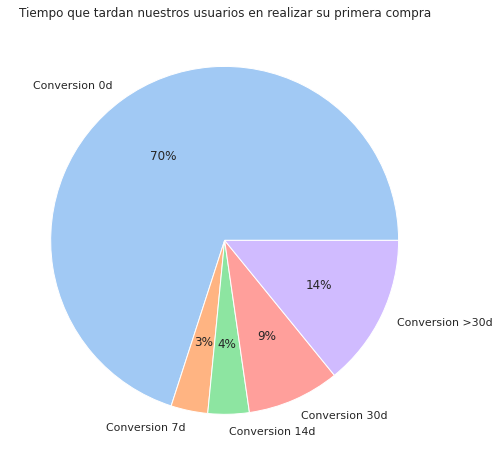

In [ ]:
colors = sns.color_palette('pastel')[0:5]
labels = ['Conversion 0d', 'Conversion 7d', 'Conversion 14d', 'Conversion 30d', 'Conversion >30d']
plt.title('Tiempo que tardan nuestros usuarios en realizar su primera compra')
plt.pie(conversion_shares['ratio'], labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

En este gráfico de pastel se visualiza la proporción de los usuarios que tenemos en cada categoria de acuerdo con los valores de `conversion_time`.

In [ ]:
conversion_by_device = conversion_first.groupby('device').agg({'conversion_time':['mean','count']}).reset_index()
conversion_by_device.columns = ['device','mean','count']
conversion_by_device['ratio_count'] = (conversion_by_device['count'] / conversion_by_device['count'].sum()*100)
conversion_by_device

,device,mean,count,ratio_count
0,desktop,16.073399,40927,81.180204
1,touch,22.340114,9488,18.819796


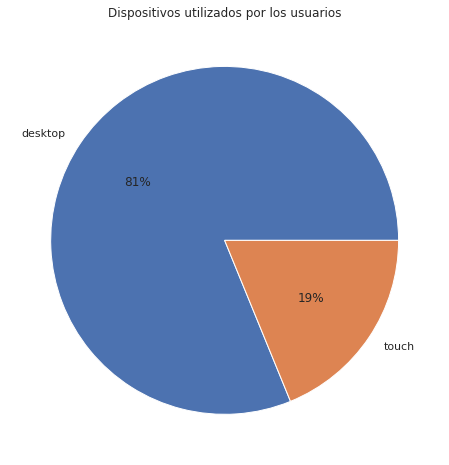

In [ ]:
colors = sns.color_palette('deep')[0:5]
labels = ['desktop', 'touch']
plt.title('Dispositivos utilizados por los usuarios')
plt.pie(conversion_by_device['ratio_count'], labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

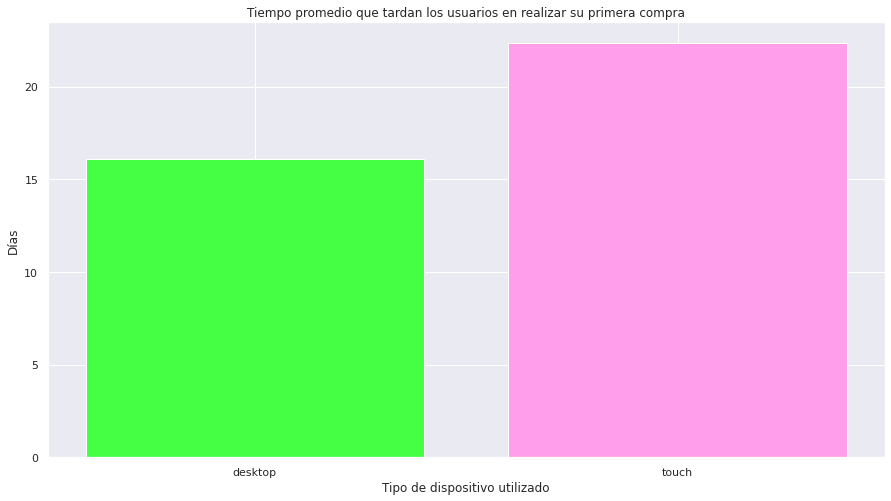

In [ ]:
plt.bar(conversion_by_device['device'], conversion_by_device['mean'], color= ['#45ff45', '#ff9eea'])
plt.title('Tiempo promedio que tardan los usuarios en realizar su primera compra')
plt.xlabel("Tipo de dispositivo utilizado")
plt.ylabel("Días")
plt.show()

Parece hasta ahora que los usuarios que utlizan dispositivos móviles son los que más tiempo tardan en realizar su compra con 54.87 días, mientras que los usuarios de la versión de escritorio tardan menos (en promedio) con 14.72 días.

In [ ]:
conversion_by_source = conversion_first.groupby('source_id').agg({'conversion_time':['mean','count']}).reset_index()
conversion_by_source.columns = ['source_id','mean','count']
conversion_by_source['ratio_count'] = (conversion_by_source['count'] / conversion_by_source['count'].sum()*100) # Agrupando por `source_id`

In [ ]:
def create_label(item):
    text = 'Source ' + str(int(item['source_id']))
    return text
conversion_by_source['label'] = conversion_by_source.apply(create_label,axis=1)
conversion_by_source = conversion_by_source[conversion_by_source['mean'] != 0].reset_index()
conversion_by_source # Agrupado por `source_id` y mostrando una columna extra con un string de la fuente

,index,source_id,mean,count,ratio_count,label
0,0,1,12.081754,5223,10.360012,Source 1
1,1,2,19.130632,6392,12.678766,Source 2
2,2,3,17.802092,13289,26.359218,Source 3
3,3,4,18.194649,12895,25.577705,Source 4
4,4,5,13.556347,9406,18.657146,Source 5
5,6,9,39.424408,1647,3.266885,Source 9
6,7,10,13.302177,1562,3.098284,Source 10


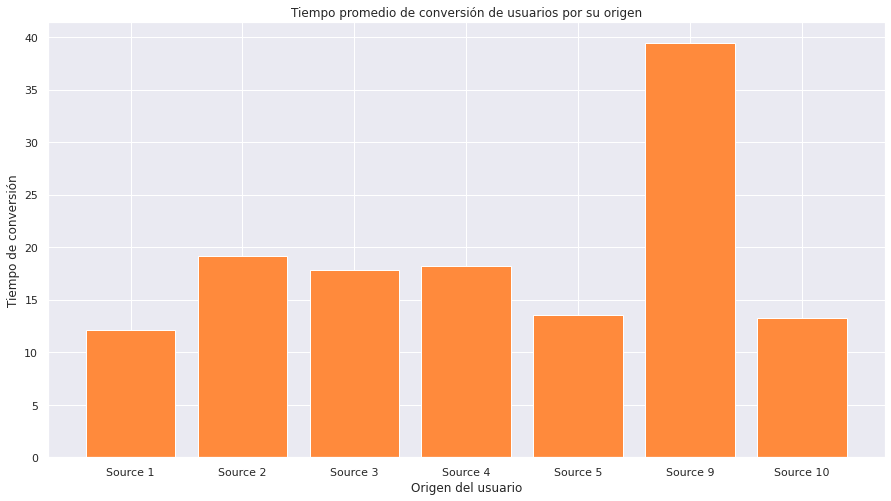

In [ ]:
plt.title('Tiempo promedio de conversión de usuarios por su origen')
plt.bar(conversion_by_source['label'], conversion_by_source['mean'], color='#ff8a3c')
plt.xlabel('Origen del usuario')
plt.ylabel('Tiempo de conversión')
plt.show()

En esta gráfica observamos el tiempo promedio que los usuarios tardan en realizar su primera compra de acuerdo con la fuente o el origen de los usuarios (cómo nos encontraron). Tenemos la gráfica de barras arriba con la visualización del tiempo de conversión y abajo una gráfica de pastel con la distribución de los usuarios provenientes de cada una.

La source #9 es la que en promedio tiene usuarios que tardan más tiempo en realizar su primera compra, y controbuye con sólo el 3% de los usuarios. La #10 también contribuye solamente con el 3% del total de usuarios pero tiene en promedio un tiempo menos de compra desde la primera visita. Las dos fuentes que más aportan en usuarios son la #3 y #4 con un 26% del total de usuarios (juntas utilizan más de la mitad del pastel). La tercer source que aporta mayor cantidad de usuarios es la #5, con un tiempo muy similar al de la #10 (las barras están al mismo nivel). Finalmente las #1 y #2 aportan el 10% y el 13% de los usuarios respectivamente y con una diferencia de 7 días en tiempo de conversión (12 y 19 en orden). 

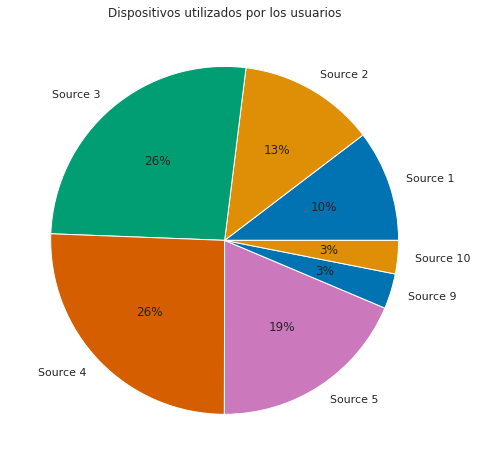

In [ ]:
colors = sns.color_palette('colorblind')[0:5]
labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
plt.title('Dispositivos utilizados por los usuarios')
plt.pie(conversion_by_source['ratio_count'], labels = conversion_by_source['label'], colors = colors, autopct='%.0f%%')
plt.show()

#### **2. Cantidad de pedidos que se hacen durante un período de tiempo dado**

In [ ]:
orders['month'] = pd.to_datetime(orders['order_month']).dt.month
orders['week'] = pd.to_datetime(orders['order_month']).dt.week
orders['day'] = pd.to_datetime(orders['order_month']).dt.day
orders['year']   = pd.to_datetime(orders['order_month']).dt.year
orders.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


,buy_ts,rev,uid,first_order,first_order_month,order_month,month,week,day,year
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01,6,22,1,2017
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01,6,22,1,2017
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01,6,22,1,2017
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01,6,22,1,2017
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01,6,22,1,2017


In [ ]:
orders_by_month = orders.groupby('month').agg({'order_month': 'count'}).reset_index()
orders_by_month

,month,order_month
0,1,4721
1,2,5281
2,3,5326
3,4,3273
4,5,4346
5,6,2355
6,7,2363
7,8,1807
8,9,3387
9,10,5679


Text(0, 0.5, 'Cantidad de órdenes')

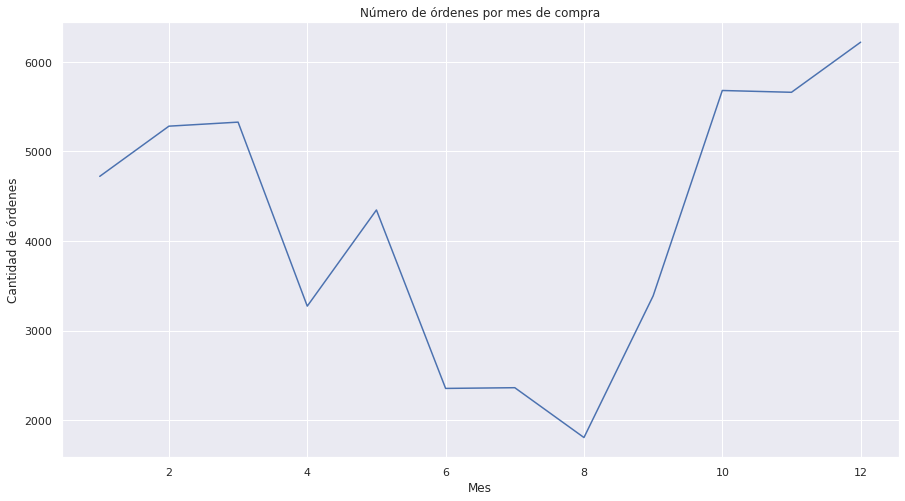

In [ ]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(data=orders_by_month, x='month', y="order_month").set(title="Número de órdenes por mes de compra")
plt.xlabel("Mes")
plt.ylabel("Cantidad de órdenes")

EN esta gráfica y tabla podemos ver la cantidad de órdenes que se realizaron cada mes. Podemos ver que efectivamente diciembre fue el mes con mayores compras, podemos asumir que es debido a la estacinalidad y las celebraciones.

#### **3. Tamaño promedio de compra**

In [ ]:
orders.pivot_table(
    index='first_order_month',
    columns='order_month',
    values='uid',
    aggfunc='nunique',
)

order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
first_order_month,,,,,,,,,,,,,
2017-06-01,2023.0,61.0,50.0,54.0,88.0,67.0,62.0,47.0,58.0,45.0,45.0,53.0,NaN
2017-07-01,NaN,1923.0,52.0,57.0,64.0,49.0,38.0,36.0,39.0,42.0,22.0,26.0,NaN
2017-08-01,NaN,NaN,1370.0,58.0,53.0,44.0,40.0,32.0,30.0,44.0,19.0,31.0,NaN
2017-09-01,NaN,NaN,NaN,2581.0,130.0,100.0,74.0,52.0,64.0,66.0,37.0,43.0,NaN
2017-10-01,NaN,NaN,NaN,NaN,4340.0,206.0,123.0,92.0,93.0,72.0,56.0,67.0,NaN
2017-11-01,NaN,NaN,NaN,NaN,NaN,4081.0,222.0,120.0,106.0,81.0,48.0,62.0,NaN
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,4383.0,146.0,103.0,97.0,50.0,63.0,NaN
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3373.0,114.0,83.0,43.0,45.0,NaN
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3651.0,118.0,58.0,39.0,NaN


En esta tabla lo que vemos es que el número único de usuarios activos va cambiando conforme el tiempo avanza para todas las cohortes, en todas el número se reduce después del primer mes y a partir del segundo el comportamiento va variando.

In [ ]:
orders_grouped_by_cohorts = orders.groupby(
    ['first_order_month', 'order_month']
).agg({'rev': 'sum', 'uid': 'nunique'})
orders_grouped_by_cohorts = orders_grouped_by_cohorts.reset_index()
orders_grouped_by_cohorts.head()

,first_order_month,order_month,rev,uid
0,2017-06-01,2017-06-01,9557.49,2023
1,2017-06-01,2017-07-01,981.82,61
2,2017-06-01,2017-08-01,885.34,50
3,2017-06-01,2017-09-01,1931.30,54
4,2017-06-01,2017-10-01,2068.58,88


In [ ]:
orders_grouped_by_cohorts['revenue_per_user'] = (orders_grouped_by_cohorts['rev'] / orders_grouped_by_cohorts['uid'])
orders_grouped_by_cohorts.tail()

,first_order_month,order_month,rev,uid,revenue_per_user
74,2018-03-01,2018-05-01,1114.87,58,19.221897
75,2018-04-01,2018-04-01,10600.69,2276,4.657597
76,2018-04-01,2018-05-01,1209.92,69,17.535072
77,2018-05-01,2018-05-01,13925.76,2988,4.660562
78,2018-06-01,2018-06-01,3.42,1,3.420000


In [ ]:
orders_grouped_by_cohorts.pivot_table(
    index='first_order_month',
    columns='order_month',
    values='revenue_per_user',
    aggfunc='mean',
)

order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
first_order_month,,,,,,,,,,,,,
2017-06-01,4.724414,16.095410,17.706800,35.764815,23.506591,22.207761,31.011935,25.033191,19.295690,27.233556,25.681333,9.804151,NaN
2017-07-01,NaN,6.010218,12.396346,21.035965,10.786094,6.938163,7.896842,6.421111,6.992821,7.382143,12.861818,11.513846,NaN
2017-08-01,NaN,NaN,5.276518,11.148793,11.851321,12.182955,16.921250,12.139062,9.620333,12.610455,21.070000,8.307419,NaN
2017-09-01,NaN,NaN,NaN,5.644529,22.188385,13.445200,138.669189,19.881538,26.095000,27.437121,16.961351,11.044651,NaN
2017-10-01,NaN,NaN,NaN,NaN,5.003733,11.287427,6.753252,7.413152,7.072796,7.255139,6.573214,7.479701,NaN
2017-11-01,NaN,NaN,NaN,NaN,NaN,5.154683,7.339054,6.786583,12.510660,7.457284,4.580833,7.564839,NaN
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,4.738191,7.816575,39.366019,48.135052,27.431400,23.518413,NaN
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.135636,8.721228,12.365542,11.199767,4.699556,NaN
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.156987,8.610000,4.942414,6.941026,NaN


In [ ]:
orders['first_order_month'] = orders['first_order_month'].astype(
    'datetime64[M]'
)
orders['order_month'] = orders['order_month'].astype('datetime64[M]')

In [ ]:
orders_grouped_by_cohorts['cohort_lifetime'] = (orders_grouped_by_cohorts['order_month'] - orders_grouped_by_cohorts['first_order_month'])

In [ ]:
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'] / np.timedelta64(1, 'M')
orders_grouped_by_cohorts['cohort_lifetime'] = (orders_grouped_by_cohorts['cohort_lifetime'].round().astype('int'))
print(
    orders_grouped_by_cohorts[
        ['first_order_month', 'order_month', 'cohort_lifetime']
    ].head()
)
print(
    orders_grouped_by_cohorts[
        ['first_order_month', 'order_month', 'cohort_lifetime']
    ].tail()
)

  first_order_month order_month  cohort_lifetime
0        2017-06-01  2017-06-01                0
1        2017-06-01  2017-07-01                1
2        2017-06-01  2017-08-01                2
3        2017-06-01  2017-09-01                3
4        2017-06-01  2017-10-01                4
   first_order_month order_month  cohort_lifetime
74        2018-03-01  2018-05-01                2
75        2018-04-01  2018-04-01                0
76        2018-04-01  2018-05-01                1
77        2018-05-01  2018-05-01                0
78        2018-06-01  2018-06-01                0


In [ ]:
revenue_per_user_pivot = orders_grouped_by_cohorts.pivot_table(
    index='first_order_month',
    columns='cohort_lifetime',
    values='revenue_per_user',
    aggfunc='mean',
)
revenue_per_user_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.724414,16.095410,17.706800,35.764815,23.506591,22.207761,31.011935,25.033191,19.295690,27.233556,25.681333,9.804151
2017-07-01,6.010218,12.396346,21.035965,10.786094,6.938163,7.896842,6.421111,6.992821,7.382143,12.861818,11.513846,NaN
2017-08-01,5.276518,11.148793,11.851321,12.182955,16.921250,12.139062,9.620333,12.610455,21.070000,8.307419,NaN,NaN
2017-09-01,5.644529,22.188385,13.445200,138.669189,19.881538,26.095000,27.437121,16.961351,11.044651,NaN,NaN,NaN
2017-10-01,5.003733,11.287427,6.753252,7.413152,7.072796,7.255139,6.573214,7.479701,NaN,NaN,NaN,NaN
2017-11-01,5.154683,7.339054,6.786583,12.510660,7.457284,4.580833,7.564839,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.738191,7.816575,39.366019,48.135052,27.431400,23.518413,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,4.135636,8.721228,12.365542,11.199767,4.699556,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.156987,8.610000,4.942414,6.941026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


En esta pirámide lo que observamos es la ganacia registrada cada mes, en promedio por usuario. Esto quiere decir que de cada cohorte de acuerdo al mes en el que realizaron su primera compra, la ganacia o revenue promedio por usuario aumentó conforme avanzó el tiempo y después de unos meses después se redujo una vez más. Para la primera cohorte podemos ver que diciembre 2017 fue el mes en el que más ganacias por usuario registramos, pasó de 4.72 unidades (no tenemos datos de si las ganacias están registradas en dólares o alguna otra moneda) a 31.01 que representa el 656% más de ganacias promedio por usuario, mientras que en mayo 2018 sólo se registró 9.8 unidades del currency, en promedio por usuario. Las demás cohortes tambiént ienen periodos en los que hay crecimiento y otros en los que las ganancias se reducen. Vamos a analizar más a fondo como cambia el comportamiento de las cohortes.

Text(111.49999999999999, 0.5, 'Mes de la primera compra')

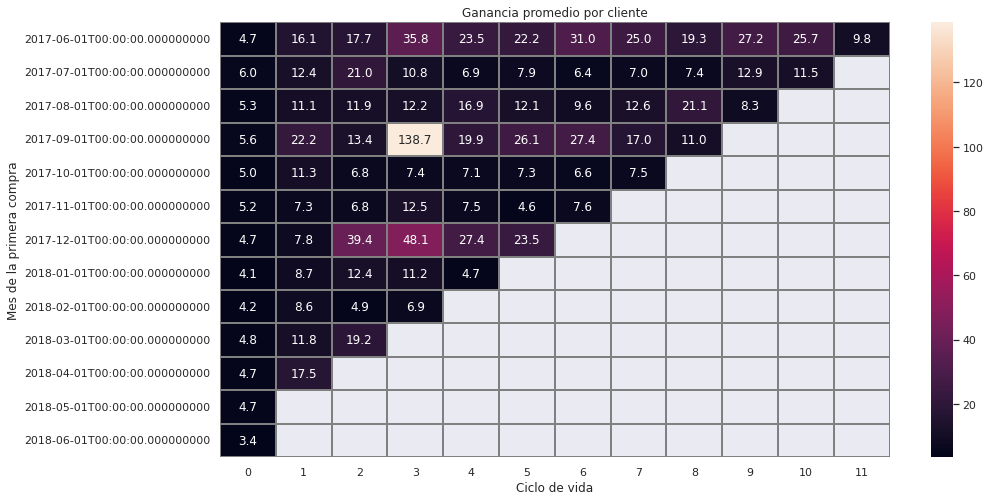

In [ ]:
plt.figure(figsize=(15, 8))
plt.title('Ganancia promedio por cliente')
sns.heatmap(
    revenue_per_user_pivot,
    annot=True,
    fmt='.1f',
    linewidths=1,
    linecolor='gray')
plt.xlabel("Ciclo de vida")
plt.ylabel("Mes de la primera compra")

Cada cohorte tuvo aumentos en los tamaños de compra respecto de la primera compra por usuario en general, con ligeras variaciones conforme avanza el tiempo durante todo el ciclo de vida de la cohorte. La cohorte de septiembre 2017 es la que podemos ver a primera vista que ha tenido durante el 3er mes del ciclo de vida el mayor promedio de compras por usuario. También la cohorte de dicembre 2017 tuvo su mayor promedio de ventas en ese tercer mes después de la primera compra, al igual que la cohorte de junio del mismo año, esto puede ser debido a el engagement que tienen los usuarios durante el ciclo de vida. Podríamos pensar que para ambas cohortes era diciembre y esto puede ser debido a la estacionalidad.

In [ ]:
purchase_size_source = conversion_first.groupby(['source_id'],as_index=False).agg({'rev':'mean'})
purchase_size_source['label'] = purchase_size_source.apply(create_label,axis=1)
purchase_size_source = purchase_size_source[purchase_size_source['rev'] != 0].reset_index()
purchase_size_source

,index,source_id,rev,label
0,0,1,5.952623,Source 1
1,1,2,7.340990,Source 2
2,2,3,4.101982,Source 3
3,3,4,4.396807,Source 4
4,4,5,5.594729,Source 5
5,5,7,1.220000,Source 7
6,6,9,3.496903,Source 9
7,7,10,2.849123,Source 10


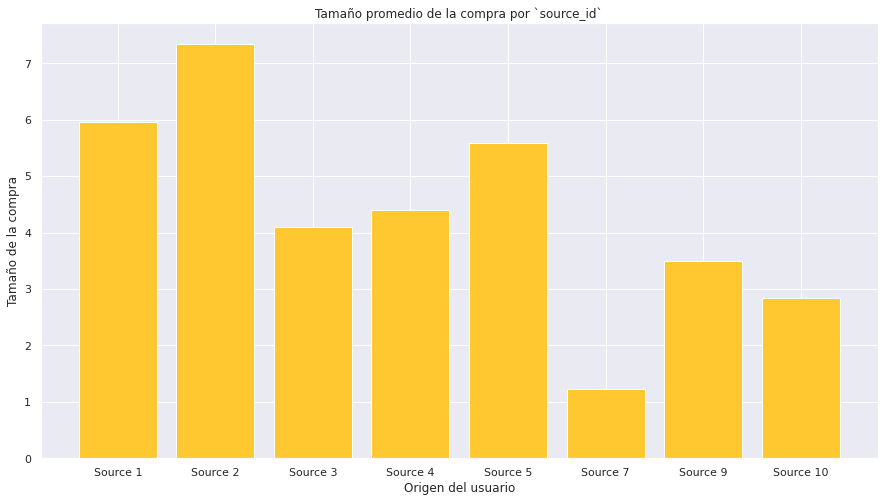

In [ ]:
plt.title('Tamaño promedio de la compra por `source_id`')
plt.bar(purchase_size_source['label'], purchase_size_source['rev'], color='#ffc830')
plt.xlabel('Origen del usuario')
plt.ylabel('Tamaño de la compra')
plt.show()

Con esta gráfica podemos observar que el tamaño promedio de las source #1, #2 y #5 son los 3 más altos, mientras que #6 y #8 ni si quiera aparecen en la gráfica. La #7 tiene el menor tamaño y lo siguen la #10 y #9. La #2 parece ser la más prometedora.

#### **4. LTV**

In [ ]:
orders['order_month'].describe() 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                   50415
unique                     13
top       2017-12-01 00:00:00
freq                     6218
first     2017-06-01 00:00:00
last      2018-06-01 00:00:00
Name: order_month, dtype: object

In [ ]:
costs_log['dt'].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                    2542
unique                    364
top       2017-06-01 00:00:00
freq                        7
first     2017-06-01 00:00:00
last      2018-05-31 00:00:00
Name: dt, dtype: object

Podemos ver que la primera orden fue del 2017 en junio y la úlitma el mismo mes pero en 2018, la fecha o mes con mayores counts fue diciembre 2017. Y que los rangos de fechas conciden, a excepción de que el último mes con ordenes registradas no es el mismo que el pultimo mes de gastos registrados, puede ser porque los datos están incompletos.

In [ ]:
orders['order_month'] = orders['order_month'].astype('datetime64[M]')
costs_log['month'] = costs_log['dt'].astype('datetime64[M]')
first_orders = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']
first_orders.head() # Sacando el mes de la primera compra

,uid,first_order_month
0,313578113262317,2018-01-01
1,1575281904278712,2017-06-01
2,2429014661409475,2017-10-01
3,2464366381792757,2018-01-01
4,2551852515556206,2017-11-01


In [ ]:
cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
cohort_sizes.head() # Sacando el número de nuevos compradores por mes

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


In [ ]:
orders_ = pd.merge(orders,first_orders, on='uid')
orders_ = orders_.rename(columns={'first_order_month_x': 'first_order_month'})
orders_['first_order_month'] = orders_['first_order_month'].astype('datetime64[M]')

In [ ]:
cohorts = orders_.groupby(['first_order_month','order_month']).agg({'rev': 'sum'}).reset_index()
cohorts.head() # Juntando las tablas para posteriormente calcular el costo por usuario y el revenue de sus compras

,first_order_month,order_month,rev
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58


In [ ]:
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
report.head() # Utilizaremos esta tabla para calcular el gross profit y la madurez de la cohorte, podría ser como el cohort lifeteime pero aquí se llamará age

,first_order_month,n_buyers,order_month,rev
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58


In [ ]:
margin_rate = 0.5

report['gp'] = report['rev'] * margin_rate
report['age'] = (
    report['order_month'] - report['first_order_month']
) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')

report.head()

,first_order_month,n_buyers,order_month,rev,gp,age
0,2017-06-01,2023,2017-06-01,9557.49,4778.745,0
1,2017-06-01,2023,2017-07-01,981.82,490.910,1
2,2017-06-01,2023,2017-08-01,885.34,442.670,2
3,2017-06-01,2023,2017-09-01,1931.30,965.650,3
4,2017-06-01,2023,2017-10-01,2068.58,1034.290,4


Text(111.49999999999999, 0.5, 'Mes de la primera compra')

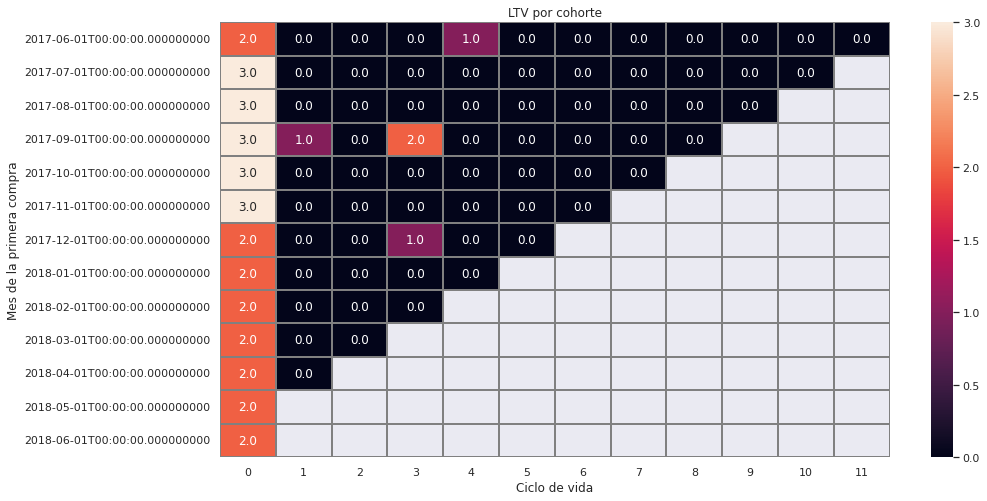

In [ ]:
report['ltv'] = report['gp'] / report['n_buyers']

output = report.pivot_table(
    index='first_order_month', columns='age', values='ltv', aggfunc='mean'
).round()

output.fillna('')
plt.figure(figsize=(15, 8))
plt.title('LTV por cohorte')
sns.heatmap(
    output,
    annot=True,
    fmt='.1f',
    linewidths=1,
    linecolor='gray')
plt.xlabel("Ciclo de vida")
plt.ylabel("Mes de la primera compra")

In [ ]:
ltv_20170601 = output.loc['2017-06-01'].sum()
ltv_20170601 

3.0

Aquí ya hemos calculado el LTV para la primera cohorte sumando el revenue de cada mes de su tiemp de vida. Es 3.0. PArece no muy alto pero veremos más adelante.

In [ ]:
total_revenue = orders['rev'].sum()
total_revenue # Total de ingresos que obtuvimos

252057.19999999998

### **Marketing**

En esta última sección vamos a determinar:

1. ¿Cuánto dinero se gastó? Total/por fuente/a lo largo del tiempo
2. ¿Cuánto costó la adquisición de clientes de cada una de las fuentes?
3. ¿Cuán rentables eran las inversiones? (ROI)


#### **1. ¿Cuánto dinero se gastó? (CAC)**

In [ ]:
costs_daily = costs_log.groupby('dt').agg({'costs':'sum'})
costs_daily.head()

,costs
dt,
2017-06-01,735.26
2017-06-02,721.19
2017-06-03,450.85
2017-06-04,761.16
2017-06-05,821.44


In [ ]:
total_costs = costs_daily['costs'].sum()
total_costs # Aquí ya vemos que el CAC es mayor que el LTV, we are in trouble.

329131.62

Text(0, 0.5, 'Costos')

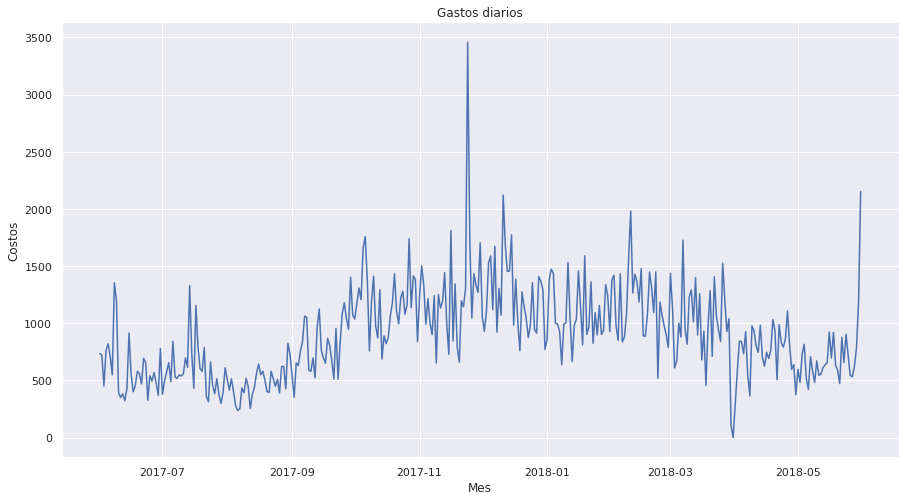

In [ ]:
sns.lineplot(data=costs_daily, x='dt', y="costs").set(title="Gastos diarios")
plt.xlabel("Mes")
plt.ylabel("Costos")

#### **2. ¿Cuánto costó la adquisición de clientes de cada una de las fuentes?**

In [ ]:
cohort_20170601 = report[report['first_order_month'] == '2017-06-01']

# calcular los costos para el mes de la cohorte
costs_20170601 = costs_log[costs_log['month'] == '2017-06-01']['costs'].sum()

n_buyers_20170601 = cohort_20170601['n_buyers'][0]
cac_20170601 = costs_20170601 / n_buyers_20170601
ltv_20170601   = output.loc['2017-06-01'].sum()

print('CAC =', cac_20170601)
print('LTV =', ltv_20170601) 

CAC = 8.905091448344043
LTV = 3.0


In [ ]:
costs_source = costs_log.groupby('source_id').agg({'costs':'sum'}).reset_index()
costs_source['label'] = costs_source.apply(create_label,axis=1)
costs_source

,source_id,costs,label
0,1,20833.27,Source 1
1,2,42806.04,Source 2
2,3,141321.63,Source 3
3,4,61073.60,Source 4
4,5,51757.10,Source 5
5,9,5517.49,Source 9
6,10,5822.49,Source 10


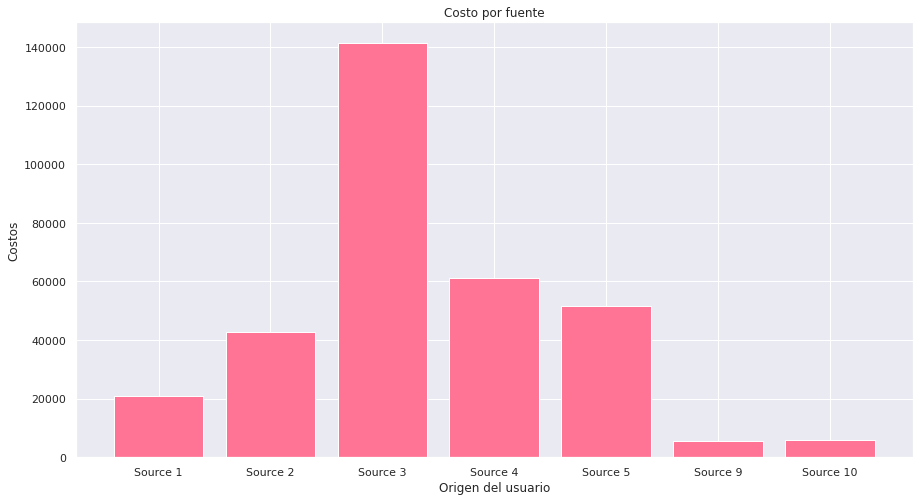

In [ ]:
plt.title('Costo por fuente')
plt.bar(costs_source['label'], costs_source['costs'], color='#ff7494')
plt.xlabel('Origen del usuario')
plt.ylabel('Costos')
plt.show()

#### **3. ¿Cuán rentables eran las inversiones? (ROI)**

In [ ]:
monthly_costs = costs_log.groupby('month').sum()
monthly_costs.head() 

,source_id,costs
month,,
2017-06-01,1020,18015.00
2017-07-01,1054,18240.59
2017-08-01,1054,14790.54
2017-09-01,1020,24368.91
2017-10-01,1054,36322.88


In [ ]:
report_ = pd.merge(report, monthly_costs, left_on='first_order_month', right_on='month')
report_['cac'] = report_['costs'] / report_['n_buyers']
report_.head() 

,first_order_month,n_buyers,order_month,rev,gp,age,ltv,source_id,costs,cac
0,2017-06-01,2023,2017-06-01,9557.49,4778.745,0,2.362207,1020,18015.0,8.905091
1,2017-06-01,2023,2017-07-01,981.82,490.910,1,0.242664,1020,18015.0,8.905091
2,2017-06-01,2023,2017-08-01,885.34,442.670,2,0.218819,1020,18015.0,8.905091
3,2017-06-01,2023,2017-09-01,1931.30,965.650,3,0.477336,1020,18015.0,8.905091
4,2017-06-01,2023,2017-10-01,2068.58,1034.290,4,0.511265,1020,18015.0,8.905091


Text(111.49999999999999, 0.5, 'Mes de la primera compra')

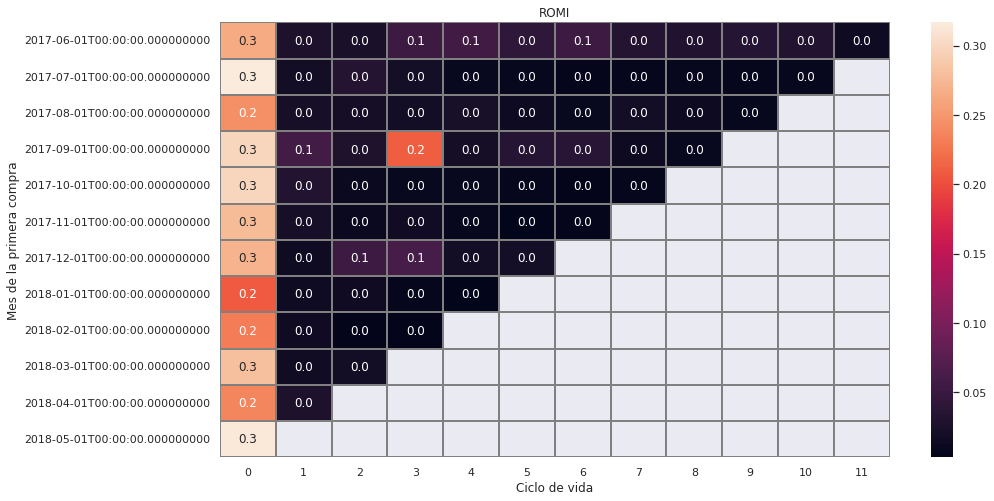

In [ ]:
report_['romi'] = report_['ltv'] / report_['cac']
output = report_.pivot_table(
    index='first_order_month', columns='age', values='romi', aggfunc='mean'
)

plt.figure(figsize=(15, 8))
plt.title('ROMI')
sns.heatmap(
    output,
    annot=True,
    fmt='.1f',
    linewidths=1,
    linecolor='gray')
plt.xlabel("Ciclo de vida")
plt.ylabel("Mes de la primera compra")

In [ ]:
output.cumsum(axis=1).round(2)
output.cumsum(axis=1).mean(axis=0)

age
0     0.270408
1     0.290992
2     0.315535
3     0.359870
4     0.391473
5     0.429938
6     0.448410
7     0.484976
8     0.526936
9     0.482244
10    0.547329
11    0.666991
dtype: float64

Con las gráficas anteriores y esta ultima tabla podemos ver que el ROMI va aumentando conforme los meses avanzan, este es el LTV/CAC ratio pero sigue siendo muy bajo, idealmente queremos que sea de 1 o mayor sin exceder la proporción de 3:1 para LTV:CAC.

## **Paso 3. Conclusión**

Durante este proyecto, primero que nada preprocesamos los datasets con los que trabajamos, arreglamos los nombres de las columnas y revisamos el contenido y tipos de datos en cada uno.

Encontramos el número de usuarios únicos para ciertos periodos de tiempo (día, semana y mes) y creamos gráficas para observar como fluctúan las cantidades de estos a través del tiempo. 

También calculamos la duración de las sesiones que tuvieron los usuarios, analizamos las fechas en las que realizaron la primera visita y también la fecha en la que realizaron la primera compra para calcular el tiempo de conversión y el engagement que tenían los usuarios con nuestra plataforma. De ahí calculamos la cantidad de usuarios que tardan ciertos periodos de tiempo en realizar su primera compra y el tipo de dispositivo utilizado fue tomado en cuenta.

Pudimos descubrir que la mayoría de los usuarios pasan 60 segundos en la plataforma y el 70% de todos los usuarios realizan su compra dentro del mismo día que realizaron su primera visita. También descubrimos que el 81% de los usuarios utilizan un dispositivo de escritorio y no móvil, además de que tardan menor tiempo en promedio en generar su primera compra desde ese dispositivo.

Analizamos también las fuentes de los usuarios, la mayoría provienen de la Source #3, #4 y #5, pero son los #1, #2 y #5 los que generan mayores ingresos. También encontramos que la fuente #3 es la que más costos genera pero no compensa  el tamaño de compra que provee por usuario.

A partir de estos datos encontramos que los gastos totales son mayores que las ganacias totales y que el ROMI podría ser más alto. La fuente #3 no es rentable, tampoco la #4 y la #6. Hay que cortar las inversiones para la #3 y podría ser que para las otras 2 se pueda aumentar el LTV con alguna estrategia ya sea de aumentar algunos precios o agregar más productos a las compras pero estaría bien hacer un análisis a parte sobre eso para saber cuál sería la mejor opción para introducir.

Estuvo dificil, but gracias por revisarlo.